# Tarea para el Hogar 04

##  1. Big Picture

LightGBM es el algoritmo estado del arte para datasets estructurados.
<br> La Bayesian Optimization es el estado del arte para optimización de hiperparámetros
<br> Las soluciones a las tres competencias de la asignatura contendrán LightGBMs y Bayesian Optimizations
<br> LightGBM ha aumentado en forma no darwiniana sus hiperparámetros en los últimos ocho años; no todos los existentes son útiles.
<br> Es necesario lograr entender cuales son los hiperparámetros relevantes de LightGBM

## 2. Hiperparámetros del LightGBM

Los objetivos de esta tarea son:


*   Aumentar la rentabilidad de la campaña de marketing de retención proactiva de clientes.
*   Generar un mejor modelo optimizando sus hiperparámetros
*   Conceptual : investigar los mas relevantes hiperparámetros de LightGBM
*   Familiarizarse con la Bayesian Optimization, sus largos tiempos de corrida y opciones para reducirlos
*   Familiarizarse con el uso de máquinas virtuales de Google Colab
*   Ver un pipeline completo de optimización de hiperparámetros y puesta en producción

LightGBM cuenta con mas de 60 hiperparámetros, siendo posible utilizar 40 al mismo tiempo, aunque no razonable.
<br> La documentación oficial de los hiperparámetros de LightGBM es  https://lightgbm.readthedocs.io/en/latest/Parameters.html#core-parameters


Se lo alerta sobre que una Optimizacion Bayesiana lleva varias horas de corrida, y usted deberá correr VARIAS optimizaciones para descubrir cuales parámetros conviene optimizar.
<br> A pesar que la próxima clase es recien en viernes 01 de agosto, inicie la tarea con tiempo, aprenda a planificar estratégicamente sus corridas como un@ científ@  de datos.

Es necesario investigar cuales son los hiperparámetros de LightGBM que vale la pena optimizar en una Bayesian Optimization, ya que los realmente utiles son apenas un reducido subconjunto.
<br>Usted deberá investigar cuales son los hiperparámetros mas relevantes de LightGBM, su primer alternativa es preguntándole a su amigo con capacidades especiales ChatGPT o sus endogámicos familiares Claude, DeepSeek, Gemini, Grok, etc
<br> La segunda alternativa es la propia documentación de LightGBM  https://lightgbm.readthedocs.io/en/latest/Parameters-Tuning.html


Adicionalmente podra buscar información como la que proveen esta diminuta muestra aleatoria de artículos ligeros:
*  https://medium.com/@sarahzouinina/a-deep-dive-into-lightgbm-how-to-choose-and-tune-parameters-7c584945842e
*  https://www.kaggle.com/code/somang1418/tuning-hyperparameters-under-10-minutes-lgbm
*  https://towardsdatascience.com/beginners-guide-to-the-must-know-lightgbm-hyperparameters-a0005a812702/


<br>  La muestra anterior se brinda a modo de ejemplo, usted deberá buscar muuuuchas  fuentes adicionales de información
<br> Tenga presente que LightGBM es el estado del arte en modelado predictivo para datasets estructurado, que son el 90% del trabajo del 95% de los Data Scientists en Argentina.

El desafío de esta tarea es:
* Qué hiperparparámetros conviene optimizar?  Las recomendaciones de los artículos ligeros es siempre sensata?  Sus autores realmente hicieron experimentos o son siemplemente escritores de entretenimiento carente de base científica?
* Elegidos los hiperparámetros, cual es el  <desde, hasta> que se debe utilizar en la Bayesian Optimization ?
* Realmente vale la pena optimizar 10 o 16 hiperparámetros al mismo tiempo ?  No resulta contraproducente una búsqueda en un espacio de tal alta dimensionalidad ?

#### 2.1  Seteo del ambiente en Google Colab

Esta parte se debe correr con el runtime en Python3
<br>Ir al menu, Runtime -> Change Runtime Type -> Runtime type ->  **Python 3**

Conectar la virtual machine donde esta corriendo Google Colab con el  Google Drive, para poder tener persistencia de archivos

In [ ]:
# primero establecer el Runtime de Python 3
from google.colab import drive
drive.mount('/content/.drive')

Para correr la siguiente celda es fundamental en Arranque en Frio haber copiado el archivo kaggle.json al Google Drive, en la carpeta indicada en el instructivo

<br>los siguientes comando estan en shell script de Linux
*   Crear las carpetas en el Google Drive
*   "instalar" el archivo kaggle.json desde el Google Drive a la virtual machine para que pueda ser utilizado por la libreria  kaggle de Python
*   Bajar el  **dataset_pequeno**  al  Google Drive  y tambien al disco local de la virtual machine que esta corriendo Google Colab



In [ ]:
%%shell

mkdir -p "/content/.drive/My Drive/dmeyf"
mkdir -p "/content/buckets"
ln -s "/content/.drive/My Drive/dmeyf" /content/buckets/b1


mkdir -p /content/buckets/b1/exp
mkdir -p /content/buckets/b1/datasets
mkdir -p /content/datasets



archivo_origen="https://storage.googleapis.com/open-courses/dmeyf2025-e4a2/competencia_01_crudo.csv"
archivo_destino="/content/datasets/competencia_01_crudo.csv"
archivo_destino_bucket="/content/buckets/b1/datasets/competencia_01_crudo.csv"

if ! test -f $archivo_destino_bucket; then
  wget  $archivo_origen  -O $archivo_destino_bucket
fi


if ! test -f $archivo_destino; then
  cp  $archivo_destino_bucket  $archivo_destino
fi


### Generacion de la clase_ternaria

Esta parte se debe correr con el runtime en lenguaje **R** Ir al menu, Runtime -> Change Runtime Tipe -> Runtime type -> R

In [ ]:
require( "data.table" )

# leo el dataset
dataset <- fread("../../Competencia 01/competencia_01_crudo.csv" )

# calculo el periodo0 consecutivo
dsimple <- dataset[, list(
    "pos" = .I,
    numero_de_cliente,
    periodo0 = as.integer(foto_mes/100)*12 +  foto_mes%%100 ) ]


# ordeno
setorder( dsimple, numero_de_cliente, periodo0 )

# calculo topes
periodo_ultimo <- dsimple[, max(periodo0) ]
periodo_anteultimo <- periodo_ultimo - 1


# calculo los leads de orden 1 y 2
dsimple[, c("periodo1", "periodo2") :=
    shift(periodo0, n=1:2, fill=NA, type="lead"),  numero_de_cliente ]

# assign most common class values = "CONTINUA"
dsimple[ periodo0 < periodo_anteultimo, clase_ternaria := "CONTINUA" ]

# calculo BAJA+1
dsimple[ periodo0 < periodo_ultimo &
    ( is.na(periodo1) | periodo0 + 1 < periodo1 ),
    clase_ternaria := "BAJA+1" ]

# calculo BAJA+2
dsimple[ periodo0 < periodo_anteultimo & (periodo0+1 == periodo1 )
    & ( is.na(periodo2) | periodo0 + 2 < periodo2 ),
    clase_ternaria := "BAJA+2" ]


# pego el resultado en el dataset original y grabo
setorder( dsimple, pos )
dataset[, clase_ternaria := dsimple$clase_ternaria ]

fwrite( dataset,
    file =  "./competencia_01.csv.gz",
    sep = ","
)

In [ ]:
setorder( dataset, foto_mes, clase_ternaria, numero_de_cliente)
dataset[, .N, list(foto_mes, clase_ternaria)]

### 2.2 Optimizacion Hiperparámetros

Esta parte se debe correr con el runtime en lenguaje R Ir al menu, Runtime -> Change Runtime Type -> Runtime type -> R

### 2.2.1 Inicio

limpio el ambiente de R

In [1]:
format(Sys.time(), "%a %b %d %X %Y")

[1] "lun sept 29 12:10:50 2025"

In [2]:
# limpio la memoria
rm(list=ls(all.names=TRUE)) # remove all objects
gc(full=TRUE, verbose=FALSE) # garbage collection

,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,650997,34.8,1431195,76.5,1431195,76.5
Vcells,1204301,9.2,8388608,64.0,2051465,15.7


### 2.2.2 Carga de Librerias

Esta parte lleva varios minutos la primera vez en Google Colab

In [50]:
# cargo las librerias que necesito
if(!require("data.table")) install.packages("data.table")
require("data.table")

if(!require("parallel")) install.packages("parallel")
require("parallel")

if(!require("R.utils")) install.packages("R.utils")
require("R.utils")

if( !require("primes") ) install.packages("primes")
require("primes")

if( !require("utils") ) install.packages("utils")
require("utils")

if( !require("rlist") ) install.packages("rlist")
require("rlist")

if( !require("yaml")) install.packages("yaml")
require("yaml")

if( !require("lightgbm") ) install.packages("lightgbm")
require("lightgbm")

if( !require("DiceKriging") ) install.packages("DiceKriging")
require("DiceKriging")

if( !require("mlrMBO") ) install.packages("mlrMBO")
require("mlrMBO")

if( !require("ggplot2") ) install.packages("ggplot2")
require("ggplot2")

Cargando paquete requerido: ggplot2



### 2.2.3 Definicion de Parametros

aqui debe cargar SU semilla primigenia
<br>recuerde cambiar el numero de experimento en cada corrida nueva

In [4]:
PARAM <- list()
PARAM$experimento <- "4940_V2A_2"
PARAM$semilla_primigenia <- 200003

In [5]:
# training y future
PARAM$train <- c(202101,202102)
PARAM$train_final <- c(202101,202102)
PARAM$future <- c(202104)
PARAM$semilla_kaggle <- 314159 #Semilla para el modelo final que va a Kaggle, primeros números de pi que sean primos.
PARAM$cortes <- seq(0, 19000, by= 100)

In [6]:
# un undersampling de 0.1  toma solo el 10% de los CONTINUA
# undersampling de 1.0  implica tomar TODOS los datos

PARAM$trainingstrategy$undersampling <- 0.5

In [7]:
# Parametros LightGBM

PARAM$hyperparametertuning$xval_folds <- 5

# parametros fijos del LightGBM que se pisaran con la parte variable de la BO
PARAM$lgbm$param_fijos <-  list(
  boosting= "gbdt", # puede ir dart, ni pruebe random_forest
  objective= "binary", #default regression
  metric= "auc", # default "" 
  first_metric_only= FALSE, # default FALSE
  boost_from_average= TRUE, # default TRUE
  feature_pre_filter= FALSE, # default TRUE
  force_row_wise= TRUE, # para reducir warnings
  verbosity= -100,

  seed= PARAM$semilla_primigenia,

  max_depth= -1L, # -1 significa no limitar,  por ahora lo dejo fijo
  min_gain_to_split= 0, # min_gain_to_split >= 0
  min_sum_hessian_in_leaf= 0.001, #  min_sum_hessian_in_leaf >= 0.0
  lambda_l1= 0.0, # lambda_l1 >= 0.0
  lambda_l2= 0.0, # lambda_l2 >= 0.0
  max_bin= 31L, # lo debo dejar fijo, no participa de la BO

  bagging_fraction= 1.0, # 0.0 < bagging_fraction <= 1.0
  pos_bagging_fraction= 1.0, # 0.0 < pos_bagging_fraction <= 1.0
  neg_bagging_fraction= 1.0, # 0.0 < neg_bagging_fraction <= 1.0
  is_unbalance= TRUE, # Default FALSE
  scale_pos_weight= 1.0, # scale_pos_weight > 0.0

  drop_rate= 0.1, # 0.0 < neg_bagging_fraction <= 1.0
  max_drop= 50, # <=0 means no limit
  skip_drop= 0.5, # 0.0 <= skip_drop <= 1.0

  extra_trees= FALSE, # default FALSE

  num_iterations= 1200, # default 100
  learning_rate= 0.02, # default 0.1
  feature_fraction= 0.5, # default 1
  num_leaves= 750, # default 31
  min_data_in_leaf= 5000 # default 20
)


Aqui se definen los hiperparámetros de LightGBM que participan de la Bayesian Optimization
- si es un numero entero debe ir makeIntegerParam
- si es un numero real (con decimales) debe ir makeNumericParam

Es muy importante leer cuales son un lower y upper permitidos y además razonables

In [8]:
# Aqui se cargan los bordes de los hiperparametros de la BO
PARAM$hypeparametertuning$hs <- makeParamSet(
  makeNumericParam("min_sum_hessian_in_leaf", lower= 0.001, upper= 0.1),
  makeNumericParam("learning_rate", lower= 0.005, upper= 0.1),
  makeNumericParam("feature_fraction", lower= 0.1, upper= 1.0),
  makeNumericParam("bagging_fraction", lower= 0.0, upper= 1.0),
  makeNumericParam("lambda_l1", lower= 0.0, upper= 10.0),
  makeNumericParam("lambda_l2", lower= 0.0, upper= 10.0),
  makeNumericParam("min_gain_to_split", lower= 0.0, upper= 15.0),
  makeIntegerParam("bagging_freq", lower= 1L, upper= 10L),
  makeIntegerParam("num_iterations", lower= 50L, upper= 3000L),
  makeIntegerParam("max_depth", lower= -1L, upper= 15L),
  makeIntegerParam("num_leaves", lower= 1L, upper= 2048L),
  makeIntegerParam("min_data_in_leaf", lower= 1L, upper= 8000L)
)

A mayor cantidad de hiperparámetros, se debe aumentar las iteraciones de la Bayesian Optimization: 30 es un valor muy tacaño, pero corre rápido deberia partir de 50, alcanzando los 100 si se dispone de tiempo.

In [9]:
PARAM$hyperparametertuning$iteraciones <- 100 # iteraciones bayesianas

In [10]:
# particionar agrega una columna llamada fold a un dataset
#   que consiste en una particion estratificada segun agrupa
# particionar( data=dataset, division=c(70,30),
#  agrupa=clase_ternaria, seed=semilla)   crea una particion 70, 30

particionar <- function(data, division, agrupa= "", campo= "fold", start= 1, seed= NA) {
  if (!is.na(seed)) set.seed(seed, "L'Ecuyer-CMRG")

  bloque <- unlist(mapply(
    function(x, y) {rep(y, x)},division, seq(from= start, length.out= length(division))))

  data[, (campo) := sample(rep(bloque,ceiling(.N / length(bloque))))[1:.N],by= agrupa]
}

In [11]:
# iniciliazo el dataset de realidad, para medir ganancia
realidad_inicializar <- function( pfuture, pparam) {

  # datos para verificar la ganancia
  drealidad <- pfuture[, list(numero_de_cliente, foto_mes, clase_ternaria)]

  particionar(drealidad,
    division= c(3, 7),
    agrupa= "clase_ternaria",
    seed= PARAM$semilla_kaggle
  )

  return( drealidad )
}

In [12]:
# evaluo ganancia en los datos de la realidad

realidad_evaluar <- function( prealidad, pprediccion) {

  prealidad[ pprediccion,
    on= c("numero_de_cliente", "foto_mes"),
    predicted:= i.Predicted
  ]

  tbl <- prealidad[, list("qty"=.N), list(fold, predicted, clase_ternaria)]

  res <- list()
  res$public  <- tbl[fold==1 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.3
  res$private <- tbl[fold==2 & predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]/0.7
  res$total <- tbl[predicted==1L, sum(qty*ifelse(clase_ternaria=="BAJA+2", 780000, -20000))]

  prealidad[, predicted:=NULL]
  return( res )
}

### 2.2.4  Preprocesamiento

In [13]:
# lectura del dataset
dataset <- fread("./competencia_01.csv.gz", stringsAsFactors= TRUE)

In [14]:
dataset_train <- dataset[foto_mes %in% PARAM$train]

In [15]:
# paso la clase a binaria que tome valores {0,1}  enteros
#  BAJA+1 y BAJA+2  son  1,   CONTINUA es 0
#  a partir de ahora ya NO puedo cortar  por prob(BAJA+2) > 1/40

dataset_train[,
  clase01 := ifelse(clase_ternaria %in% c("BAJA+2","BAJA+1"), 1L, 0L)
]

In [16]:
# defino los datos que forma parte del training
# aqui se hace el undersampling de los CONTINUA
# notar que para esto utilizo la SEGUNDA semilla

set.seed(PARAM$semilla_primigenia, kind = "L'Ecuyer-CMRG")
dataset_train[, azar := runif(nrow(dataset_train))]
dataset_train[, training := 0L]

dataset_train[
  foto_mes %in%  PARAM$train &
    (azar <= PARAM$trainingstrategy$undersampling | clase_ternaria %in% c("BAJA+1", "BAJA+2")),
  training := 1L
]

In [17]:
# los campos que se van a utilizar

campos_buenos <- setdiff(
  colnames(dataset_train),
  c("clase_ternaria", "clase01", "azar", "training")
)

In [18]:
# dejo los datos en el formato que necesita LightGBM

dtrain <- lgb.Dataset(
  data= data.matrix(dataset_train[training == 1L, campos_buenos, with= FALSE]),
  label= dataset_train[training == 1L, clase01],
  free_raw_data= FALSE
)

nrow(dtrain)
ncol(dtrain)

[1] 163737

[1] 154

2.2.5 Configuracion Bayesian Optimization

In [19]:
# En el argumento x llegan los parmaetros de la bayesiana
#  devuelve la AUC en cross validation del modelo entrenado

EstimarGanancia_AUC_lightgbm <- function(x) {

  # x pisa (o agrega) a param_fijos
  param_completo <- modifyList(PARAM$lgbm$param_fijos, x)

  # entreno LightGBM
  modelocv <- lgb.cv(
    data= dtrain,
    nfold= PARAM$hyperparametertuning$xval_folds,
    stratified= TRUE,
    param= param_completo
  )

  # obtengo la ganancia
  AUC <- modelocv$best_score

  # hago espacio en la memoria
  rm(modelocv)
  gc(full= TRUE, verbose= FALSE)

  message(format(Sys.time(), "%a %b %d %X %Y"), " AUC ", AUC)

  return(AUC)
}

In [20]:
# Aqui comienza la configuracion de la Bayesian Optimization

# en este archivo quedan la evolucion binaria de la BO
kbayesiana <- "bayesiana.RDATA"

funcion_optimizar <- EstimarGanancia_AUC_lightgbm # la funcion que voy a maximizar

configureMlr(show.learner.output= FALSE)

# configuro la busqueda bayesiana,  los hiperparametros que se van a optimizar
# por favor, no desesperarse por lo complejo

obj.fun <- makeSingleObjectiveFunction(
  fn= funcion_optimizar, # la funcion que voy a maximizar
  minimize= FALSE, # estoy Maximizando la ganancia
  noisy= TRUE,
  par.set= PARAM$hypeparametertuning$hs, # definido al comienzo del programa
  has.simple.signature= FALSE # paso los parametros en una lista
)

# cada 600 segundos guardo el resultado intermedio
ctrl <- makeMBOControl(
  save.on.disk.at.time= 600, # se graba cada 600 segundos
  save.file.path= kbayesiana
) # se graba cada 600 segundos

# indico la cantidad de iteraciones que va a tener la Bayesian Optimization
ctrl <- setMBOControlTermination(
  ctrl,
  iters= PARAM$hyperparametertuning$iteraciones
) # cantidad de iteraciones

# defino el método estandar para la creacion de los puntos iniciales,
# los "No Inteligentes"
ctrl <- setMBOControlInfill(ctrl, crit= makeMBOInfillCritEI())

# establezco la funcion que busca el maximo
surr.km <- makeLearner(
  "regr.km",
  predict.type= "se",
  covtype= "matern3_2",
  control= list(trace= TRUE)
)


2.2.6 Corrida Bayesian Optimization

In [21]:
# inicio la optimizacion bayesiana, retomando si ya existe
# es la celda mas lenta de todo el notebook

if (!file.exists(kbayesiana)) {
  bayesiana_salida <- mbo(obj.fun, learner= surr.km, control= ctrl)
} else {
  bayesiana_salida <- mboContinue(kbayesiana) # retomo en caso que ya exista
}

Computing y column(s) for design. Not provided.

lun sept 29 12:13:07 2025 AUC 0.931407600206146

lun sept 29 12:14:48 2025 AUC 0.927150680141032

lun sept 29 12:16:11 2025 AUC 0.932766073398486

lun sept 29 12:17:41 2025 AUC 0.93765445020784

lun sept 29 12:20:06 2025 AUC 0.932382870001722

lun sept 29 12:20:48 2025 AUC 0.932674997289019

lun sept 29 12:22:46 2025 AUC 0.935078031782577

lun sept 29 12:24:53 2025 AUC 0.931195963553283

lun sept 29 12:26:14 2025 AUC 0.930088086308943

lun sept 29 12:26:42 2025 AUC 0.931891345690352

lun sept 29 12:27:05 2025 AUC 0.5

lun sept 29 12:32:04 2025 AUC 0.938789920404872

lun sept 29 12:35:30 2025 AUC 0.938678411226793

lun sept 29 12:37:31 2025 AUC 0.933209703545001

lun sept 29 12:38:22 2025 AUC 0.927081939321893

lun sept 29 12:39:08 2025 AUC 0.915179279738477

lun sept 29 12:40:45 2025 AUC 0.936285015462043

lun sept 29 12:41:11 2025 AUC 0.928230448009456

lun sept 29 12:42:32 2025 AUC 0.932911801994876

lun sept 29 12:43:40 2025 AUC 0.917

In [22]:

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)
colnames( tb_bayesiana)

[1] "min_sum_hessian_in_leaf" "learning_rate"          
 [3] "feature_fraction"        "bagging_fraction"       
 [5] "lambda_l1"               "lambda_l2"              
 [7] "min_gain_to_split"       "bagging_freq"           
 [9] "num_iterations"          "max_depth"              
[11] "num_leaves"              "min_data_in_leaf"       
[13] "y"                       "dob"                    
[15] "eol"                     "error.message"          
[17] "exec.time"               "ei"                     
[19] "error.model"             "train.time"             
[21] "prop.type"               "propose.time"           
[23] "se"                      "mean"

In [23]:
# almaceno los resultados de la Bayesian Optimization
# y capturo los mejores hiperparametros encontrados

tb_bayesiana <- as.data.table(bayesiana_salida$opt.path)

tb_bayesiana[, iter := .I]

# ordeno en forma descendente por AUC = y
setorder(tb_bayesiana, -y)

# grabo para eventualmente poder utilizarlos en OTRA corrida
fwrite( tb_bayesiana,
  file= "BO_log.txt",
  sep= "\t"
)

# los mejores hiperparámetros son los que quedaron en el registro 1 de la tabla
PARAM$out$lgbm$mejores_hiperparametros <- tb_bayesiana[
  1, # el primero es el de mejor AUC
  setdiff(colnames(tb_bayesiana),
    c("y","dob","eol","error.message","exec.time","ei","error.model",
      "train.time","prop.type","propose.time","se","mean","iter")),
  with= FALSE
]


PARAM$out$lgbm$y <- tb_bayesiana[1, y]


In [24]:
write_yaml( PARAM, file="PARAM.yml")

In [25]:
print(PARAM$out$lgbm$mejores_hiperparametros)
print(PARAM$out$lgbm$y)

   min_sum_hessian_in_leaf learning_rate feature_fraction bagging_fraction
                     <num>         <num>            <num>            <num>
1:              0.02051487     0.0532346         0.549293         0.945844
   lambda_l1 lambda_l2 min_gain_to_split bagging_freq num_iterations max_depth
       <num>     <num>             <num>        <int>          <int>     <int>
1:  1.607724  4.457547          0.322211            3           1194        14
   num_leaves min_data_in_leaf
        <int>            <int>
1:       1133             1214


[1] 0.9414999


## 2.3  Produccion

### Final Training
Construyo el modelo final, que es uno solo, no hace ningun tipo de particion < training, validation, testing>]

#### Final Training Dataset

Aqui esta la gran decision de en qué meses hago el Final Training
<br> debo utilizar los mejores hiperparámetros que encontré en la  optimización bayesiana

In [26]:
# clase01
dataset[, clase01 := ifelse(clase_ternaria %in% c("BAJA+1", "BAJA+2"), 1L, 0L)]

In [27]:
dataset_train <- dataset[foto_mes %in% PARAM$train_final]
dataset_train[,.N,clase_ternaria]

clase_ternaria,N
<fct>,<int>
CONTINUA,320372
BAJA+2,1857
BAJA+1,1453


In [28]:
# dejo los datos en el formato que necesita LightGBM

dtrain_final <- lgb.Dataset(
  data= data.matrix(dataset_train[, campos_buenos, with= FALSE]),
  label= dataset_train[, clase01]
)

#### Final Training Hyperparameters

In [29]:
param_final <- modifyList(PARAM$lgbm$param_fijos,
  PARAM$out$lgbm$mejores_hiperparametros)

param_final

$boosting
[1] "gbdt"

$objective
[1] "binary"

$metric
[1] "auc"

$first_metric_only
[1] FALSE

$boost_from_average
[1] TRUE

$feature_pre_filter
[1] FALSE

$force_row_wise
[1] TRUE

$verbosity
[1] -100

$seed
[1] 200003

$max_depth
[1] 14

$min_gain_to_split
[1] 0.322211

$min_sum_hessian_in_leaf
[1] 0.02051487

$lambda_l1
[1] 1.607724

$lambda_l2
[1] 4.457547

$max_bin
[1] 31

$bagging_fraction
[1] 0.945844

$pos_bagging_fraction
[1] 1

$neg_bagging_fraction
[1] 1

$is_unbalance
[1] TRUE

$scale_pos_weight
[1] 1

$drop_rate
[1] 0.1

$max_drop
[1] 50

$skip_drop
[1] 0.5

$extra_trees
[1] FALSE

$num_iterations
[1] 1194

$learning_rate
[1] 0.0532346

$feature_fraction
[1] 0.549293

$num_leaves
[1] 1133

$min_data_in_leaf
[1] 1214

$bagging_freq
[1] 3

#### Training
Genero el modelo final, siempre sobre TODOS los datos de  final_train, sin hacer ningun tipo de undersampling de la clase mayoritaria y mucho menos cross validation.

In [30]:
# este punto es muy SUTIL  y será revisado en la Clase 05

param_normalizado <- copy(param_final)
param_normalizado$min_data_in_leaf <-  round(param_final$min_data_in_leaf / PARAM$trainingstrategy$undersampling)

In [43]:
# entreno LightGBM

param_normalizado$seed <- 200003

modelo_final <- lgb.train(
  data= dtrain_final,
  param= param_normalizado
)

In [32]:
# ahora imprimo la importancia de variables

tb_importancia <- as.data.table(lgb.importance(modelo_final))
archivo_importancia <- "impo.txt"

fwrite(tb_importancia,
  file= archivo_importancia,
  sep= "\t"
)

In [33]:
# grabo a disco el modelo en un formato para seres humanos ... ponele ...
lgb.save(modelo_final, "modelo.txt" )

### Scoring

Aplico el modelo final a los datos del futuro

In [44]:
# aplico el modelo a los datos sin clase
dfuture <- dataset[foto_mes %in% PARAM$future]

# aplico el modelo a los datos nuevos
prediccion <- predict(
  modelo_final,
  data.matrix(dfuture[, campos_buenos, with= FALSE])
)

In [45]:
# inicilizo el dataset  drealidad
drealidad <- realidad_inicializar( dfuture, PARAM)

#### Tabla Prediccion

In [46]:
# tabla de prediccion

tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes)]
tb_prediccion[, prob := prediccion ]

# grabo las probabilidad del modelo
fwrite(tb_prediccion,
  file= "prediccion.txt",
  sep= "\t"
)

Kaggle Competition Submit

In [37]:
PARAM$cortes

[1]     0   100   200   300   400   500   600   700   800   900  1000  1100
 [13]  1200  1300  1400  1500  1600  1700  1800  1900  2000  2100  2200  2300
 [25]  2400  2500  2600  2700  2800  2900  3000  3100  3200  3300  3400  3500
 [37]  3600  3700  3800  3900  4000  4100  4200  4300  4400  4500  4600  4700
 [49]  4800  4900  5000  5100  5200  5300  5400  5500  5600  5700  5800  5900
 [61]  6000  6100  6200  6300  6400  6500  6600  6700  6800  6900  7000  7100
 [73]  7200  7300  7400  7500  7600  7700  7800  7900  8000  8100  8200  8300
 [85]  8400  8500  8600  8700  8800  8900  9000  9100  9200  9300  9400  9500
 [97]  9600  9700  9800  9900 10000 10100 10200 10300 10400 10500 10600 10700
[109] 10800 10900 11000 11100 11200 11300 11400 11500 11600 11700 11800 11900
[121] 12000 12100 12200 12300 12400 12500 12600 12700 12800 12900 13000 13100
[133] 13200 13300 13400 13500 13600 13700 13800 13900 14000 14100 14200 14300
[145] 14400 14500 14600 14700 14800 14900 15000 15100 15200 15300 15400 15500
[157] 15600 15700 15800 15900 16000 16100 16200 16300 16400 16500 16600 16700
[169] 16800 16900 17000 17100 17200 17300 17400 17500 17600 17700 17800 17900
[181] 18000 18100 18200 18300 18400 18500 18600 18700 18800 18900 19000

In [47]:
# genero archivos con los  "envios" mejores
# suba TODOS los archivos a Kaggle

# ordeno por probabilidad descendente
setorder(tb_prediccion, -prob)

dir.create("kaggle")
resultados <- data.table()

for (envios in PARAM$cortes) {

  tb_prediccion[, Predicted := 0L] # seteo inicial a 0
  tb_prediccion[1:envios, Predicted := 1L] # marco los primeros

  archivo_kaggle <- paste0("./kaggle/KA", PARAM$experimento, "_", envios, ".csv")

  # grabo el archivo
  fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
    file= archivo_kaggle,
    sep= ","
  )

  res <- realidad_evaluar( drealidad, tb_prediccion)
  
  resultados <- rbind(
    resultados,
    data.table(
      clientes = envios,
      ganancia_total = res$total,
      ganancia_public = res$public,
      ganancia_private = res$private
    )
  )

  options(scipen = 999)
  cat( "Envios=", envios, "\t",
    " TOTAL=", res$total,
    "  Public=", res$public,
    " Private=", res$private,
    "\n",
    sep= ""
  )

}

Warning message in dir.create("kaggle"):
"'kaggle' already exists"


Envios=0	 TOTAL=-20000  Public=0 Private=-28571.43
Envios=100	 TOTAL=18000000  Public=16666667 Private=18571429
Envios=200	 TOTAL=36800000  Public=36400000 Private=36971429
Envios=300	 TOTAL=45200000  Public=45066667 Private=45257143
Envios=400	 TOTAL=63200000  Public=56333333 Private=66142857
Envios=500	 TOTAL=74000000  Public=57200000 Private=81200000
Envios=600	 TOTAL=85600000  Public=55000000 Private=98714286
Envios=700	 TOTAL=101200000  Public=69000000 Private=115000000
Envios=800	 TOTAL=110400000  Public=74666667 Private=125714286
Envios=900	 TOTAL=122000000  Public=83266667 Private=138600000
Envios=1000	 TOTAL=132800000  Public=96733333 Private=148257143
Envios=1100	 TOTAL=140400000  Public=98000000 Private=158571429
Envios=1200	 TOTAL=152800000  Public=111933333 Private=170314286
Envios=1300	 TOTAL=161200000  Public=123133333 Private=177514286
Envios=1400	 TOTAL=171200000  Public=141733333 Private=183828571
Envios=1500	 TOTAL=176400000  Public=144666667 Private=190000000
Envios

Warning message:
"Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead."


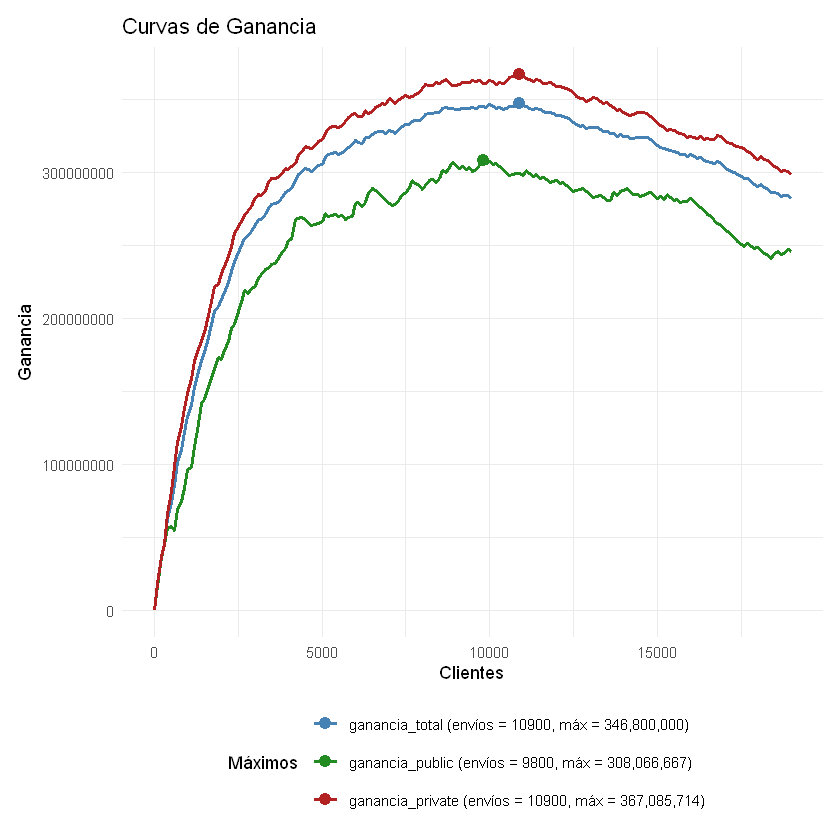

In [51]:
# pasamos a formato largo
resultados_long <- melt(
  resultados,
  id.vars = "clientes",
  measure.vars = c("ganancia_total", "ganancia_public", "ganancia_private"),
  variable.name = "tipo",
  value.name = "ganancia"
)

# calcular máximos por tipo
maximos <- resultados_long[, .SD[which.max(ganancia)], by = tipo]

# crear etiquetas personalizadas para la leyenda
etiquetas <- paste0(
  maximos$tipo,
  " (envíos = ", maximos$clientes, ", máx = ", format(maximos$ganancia, big.mark = ","), ")"
)
names(etiquetas) <- maximos$tipo

# gráfico
ggplot(resultados_long, aes(x = clientes, y = ganancia, color = tipo)) +
  geom_line(size = 1) +
  # agregar puntos en los máximos
  geom_point(data = maximos, aes(x = clientes, y = ganancia, color = tipo), size = 3) +
  labs(
    title = "Curvas de Ganancia",
    x = "Clientes",
    y = "Ganancia",
    color = "Máximos"
  ) +
  scale_color_manual(values = c("ganancia_total" = "steelblue",
                                "ganancia_public" = "forestgreen",
                                "ganancia_private" = "firebrick"),
                     labels = etiquetas) +
  theme_minimal() +
  theme(
    plot.margin = margin(10, 10, 10, 10),  # top, right, bottom, left
    legend.position = "bottom")+
  guides(color = guide_legend(nrow = 3, byrow = TRUE))
  #+ ggsave("curvas.png", width = 10, height = 6)

In [39]:
write_yaml( PARAM, file="PARAM.yml")

In [40]:

format(Sys.time(), "%a %b %d %X %Y")

[1] "lun sept 29 17:24:31 2025"

Finalmente usted deberá cargar el resultado de su corrida en la Google Sheet Colaborativa,  hoja **TareaHogar04**
<br> Siéntase libre de agregar las columnas que hagan falta a la planilla

In [ ]:
# Definir las 5 semillas fijas para el ensemble
semillas_fijas <- c(200003,300007,400009,500009,600011)

# Inicializar una lista para almacenar las predicciones de cada modelo
list_predicciones <- list()

# Iniciar el bucle para entrenar y predecir con cada una de las semillas
for (semilla in semillas_fijas) {

  # Asignar la semilla actual a los parámetros del modelo
  param_normalizado$seed <- semilla
  
  # Entrenar el modelo LightGBM
  modelo_temp <- lgb.train(
    data = dtrain_final,
    param = param_normalizado
  )
  
  # Preparar los datos sin clase para la predicción
  dfuture <- dataset[foto_mes %in% PARAM$future]
  
  # Realizar la predicción con el modelo actual
  prediccion_temp <- predict(
    modelo_temp,
    data.matrix(dfuture[, campos_buenos, with = FALSE])
  )
  
  # Guardar la predicción en la lista
  list_predicciones[[length(list_predicciones) + 1]] <- prediccion_temp
}

# Unir las predicciones de todos los modelos en una sola matriz
matriz_predicciones <- do.call(cbind, list_predicciones)

# Calcular el promedio de las predicciones para obtener el resultado final del ensemble
prediccion_ensemble <- rowMeans(matriz_predicciones)

# Ahora, la variable 'prediccion_ensemble' contiene el resultado final del ensemble.
# A partir de aquí, el código continúa usando esta nueva variable.

# Inicilizo el dataset drealidad
drealidad <- realidad_inicializar( dfuture, PARAM)

# Crear la tabla de predicción
tb_prediccion <- dfuture[, list(numero_de_cliente, foto_mes)]
tb_prediccion[, prob := prediccion_ensemble ]

# Generar los "envios" para los mejores resultados
# Ordenar por probabilidad descendente
setorder(tb_prediccion, -prob)

# Crear el directorio 'kaggle' si no existe
dir.create("kaggle_promediado")

for (envios in PARAM$cortes) {

  tb_prediccion[, Predicted := 0L] # seteo inicial a 0
  tb_prediccion[1:envios, Predicted := 1L] # marcar los primeros envíos
  
  # Nombre del archivo para Kaggle
  archivo_kaggle <- paste0("./kaggle_promediado/KA", PARAM$experimento, "_", envios, ".csv")
  
  # Guardar el archivo CSV
  fwrite(tb_prediccion[, list(numero_de_cliente, Predicted)],
         file = archivo_kaggle,
         sep = ","
  )
  
  # Evaluar el resultado
  res <- realidad_evaluar( drealidad, tb_prediccion)
  
  # Imprimir los resultados en la consola
  options(scipen = 999)
  cat( "Envios=", envios, "\t",
       " TOTAL=", res$total,
       "  Public=", res$public,
       " Private=", res$private,
       "\n",
       sep= ""
  )
}

Warning message in dir.create("kaggle_promediado"):
"'kaggle_promediado' already exists"


Envios=0	 TOTAL=-20000  Public=0 Private=-28571.43
Envios=100	 TOTAL=16400000  Public=19400000 Private=15114286
Envios=200	 TOTAL=34400000  Public=36133333 Private=33657143
Envios=300	 TOTAL=46800000  Public=42466667 Private=48657143
Envios=400	 TOTAL=60800000  Public=51000000 Private=65000000
Envios=500	 TOTAL=76400000  Public=59933333 Private=83457143
Envios=600	 TOTAL=86400000  Public=60600000 Private=97457143
Envios=700	 TOTAL=95600000  Public=66466667 Private=108085714
Envios=800	 TOTAL=113600000  Public=77666667 Private=129000000
Envios=900	 TOTAL=123600000  Public=88466667 Private=138657143
Envios=1000	 TOTAL=140800000  Public=99733333 Private=158400000
Envios=1100	 TOTAL=148400000  Public=102666667 Private=168000000
Envios=1200	 TOTAL=158400000  Public=111333333 Private=178571429
Envios=1300	 TOTAL=162000000  Public=119866667 Private=180057143
Envios=1400	 TOTAL=172800000  Public=141466667 Private=186228571
Envios=1500	 TOTAL=182000000  Public=152933333 Private=194457143
Envios

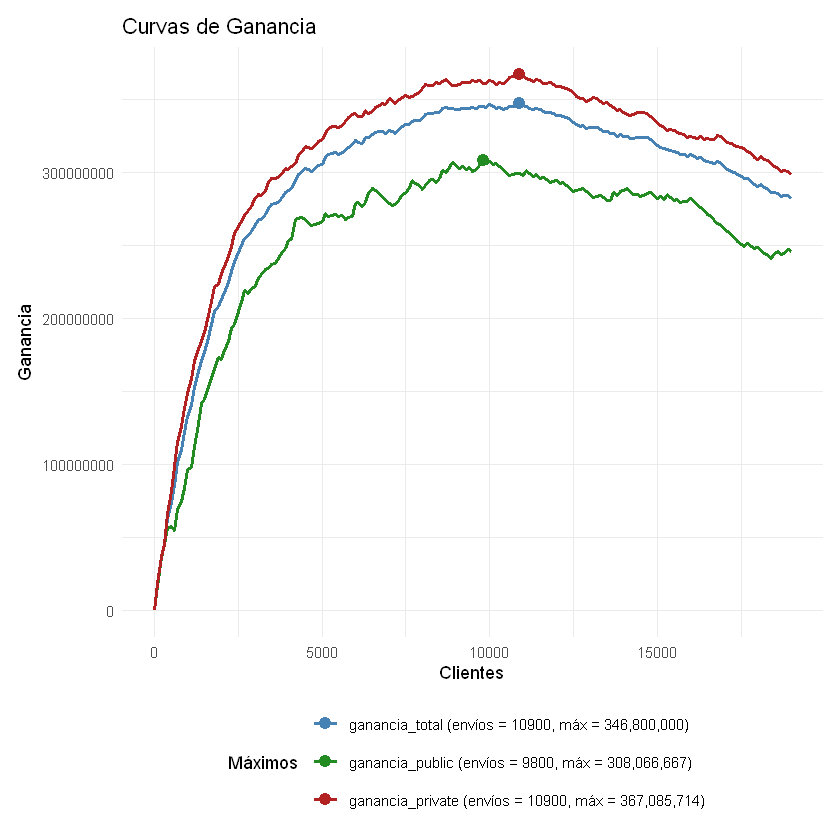

In [53]:
# pasamos a formato largo
resultados_long <- melt(
  resultados,
  id.vars = "clientes",
  measure.vars = c("ganancia_total", "ganancia_public", "ganancia_private"),
  variable.name = "tipo",
  value.name = "ganancia"
)

# calcular máximos por tipo
maximos <- resultados_long[, .SD[which.max(ganancia)], by = tipo]

# crear etiquetas personalizadas para la leyenda
etiquetas <- paste0(
  maximos$tipo,
  " (envíos = ", maximos$clientes, ", máx = ", format(maximos$ganancia, big.mark = ","), ")"
)
names(etiquetas) <- maximos$tipo

# gráfico
ggplot(resultados_long, aes(x = clientes, y = ganancia, color = tipo)) +
  geom_line(size = 1) +
  # agregar puntos en los máximos
  geom_point(data = maximos, aes(x = clientes, y = ganancia, color = tipo), size = 3) +
  labs(
    title = "Curvas de Ganancia",
    x = "Clientes",
    y = "Ganancia",
    color = "Máximos"
  ) +
  scale_color_manual(values = c("ganancia_total" = "steelblue",
                                "ganancia_public" = "forestgreen",
                                "ganancia_private" = "firebrick"),
                     labels = etiquetas) +
  theme_minimal() +
  theme(
    plot.margin = margin(10, 10, 10, 10),  # top, right, bottom, left
    legend.position = "bottom")+
  guides(color = guide_legend(nrow = 3, byrow = TRUE))
  #+ ggsave("curvas.png", width = 10, height = 6)